In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
from torchvision import datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import copy
import time

In [2]:
# Wczytanie danych CIFAR10
ROOT = 'data' 
train_data = datasets.CIFAR10(root = ROOT, train = True, download = True)

# Średnia i odchylenia standardowe, aby znormalizować dane
mean = train_data.data.mean(axis = (0,1,2)) / 255 # 3 kanały RGB, każdy z wartocią max = 255, więc 3 średnie, każda
# dla innego koloru
std = train_data.data.std(axis = (0,1,2)) / 255

print(f'Średnie: {mean}')
print(f'Odchylenia: {std}')

Files already downloaded and verified
Średnie: [0.49139968 0.48215841 0.44653091]
Odchylenia: [0.24703223 0.24348513 0.26158784]


In [3]:
# Transformacje na danych - analogicznie jak w lab 4 tylko z MNIST na CIFAR10
# Definicja transformacji zbioru testowego oraz treningowego
train_transforms = transforms.Compose([
  transforms.RandomRotation(5),
  transforms.RandomCrop(32, padding=2),
  transforms.RandomHorizontalFlip(0.5),  
  transforms.ToTensor(),
  transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([                                   
  transforms.ToTensor(),
  transforms.Normalize(mean=mean, std=std)
])

train_data = datasets.CIFAR10(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.CIFAR10(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

# Tworzenie zbioru walidacyjnego z treningowego
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples # 10% na walidacyjny
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [0]:
"""
  Reprezentacja obrazka w PyTorch - [channels, height, width]
  Reprezentacja obrazka w matplotlib - [height, width, channels]
  Stąd zmiana kolejności wymiarów obrazka
"""
def plot_images(images, labels, classes, normalize = False):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]

    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')
  fig.show()


"""
  Matplotlib wymaga wartości pixela z przedziału [0,1]. Po naszej normalizacji wartości są inne
"""
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image


def plot_filter(images, filter, normalize = True):
  images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
  filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
  filter = filter.repeat(3, 3, 1, 1)
  n_images = images.shape[0]
  filtered_images = F.conv2d(images, filter)
  images = images.permute(0, 2, 3, 1)
  filtered_images = filtered_images.permute(0, 2, 3, 1)
  fig = plt.figure(figsize = (25, 5))

  for i in range(n_images):
    image = images[i]
    if normalize:
      image = normalize_image(image)
    ax = fig.add_subplot(2, n_images, i+1)
    ax.imshow(image)
    ax.set_title('Original')
    ax.axis('off')
    image = filtered_images[i]

    if normalize:
      image = normalize_image(image)

    ax = fig.add_subplot(2, n_images, n_images+i+1)
    ax.imshow(image)
    ax.set_title(f'Filtered')
    ax.axis('off')

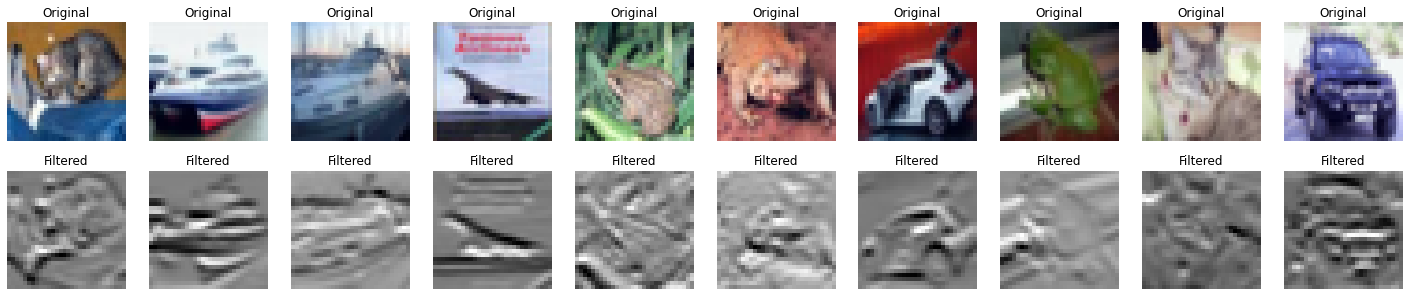

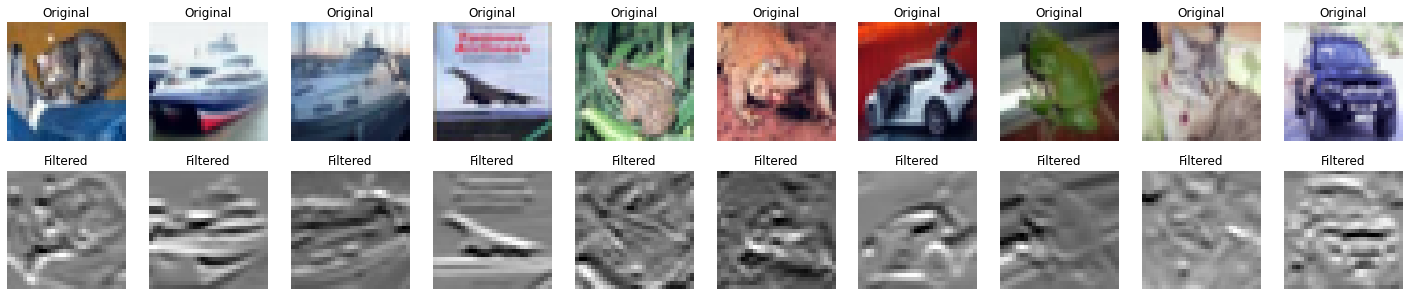

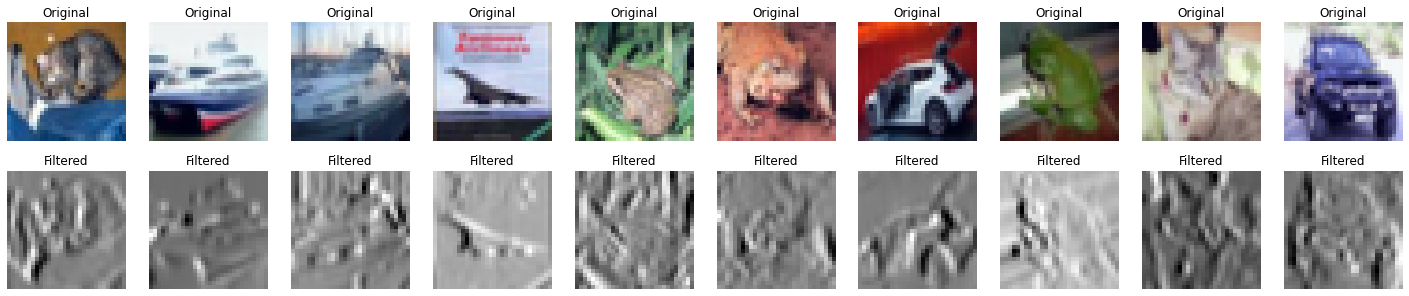

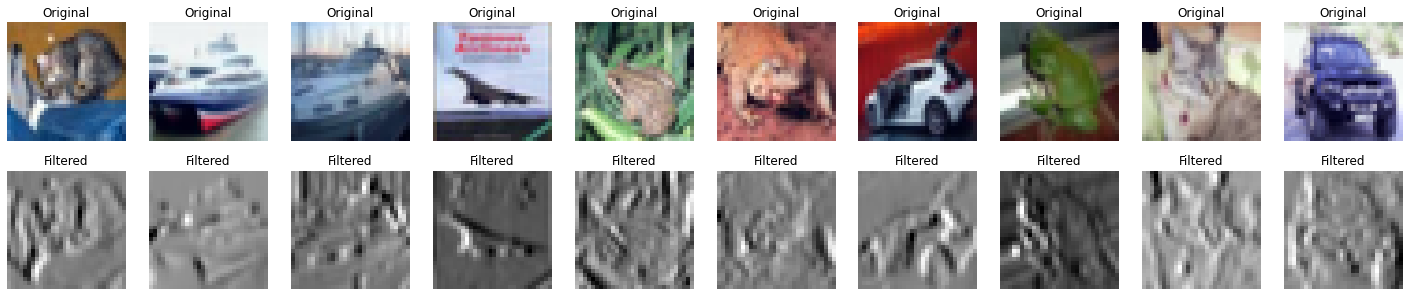

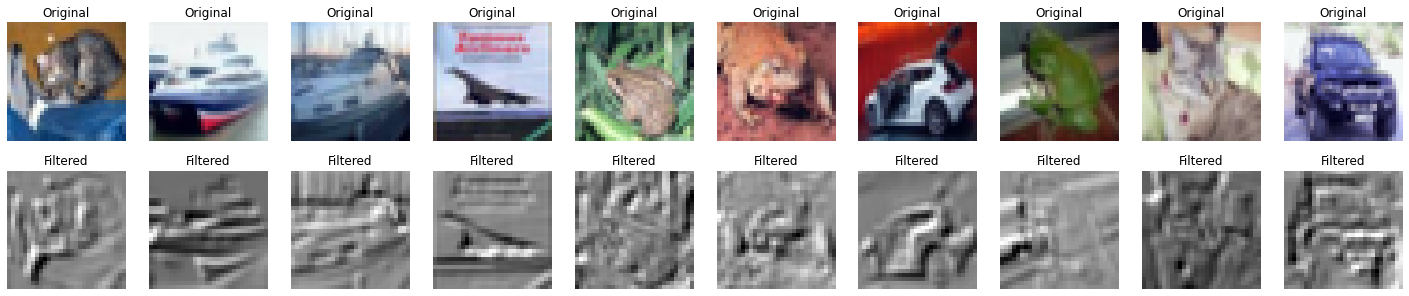

In [5]:
# Wyświetlenie obrazków z CIFAR10 z filtrami z laboratorium 4
N_IMAGES = 10
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
horizontal_filter = [[-1, -2, -1],
                     [0, 0, 0],
                     [1, 2, 1]]
plot_filter(images, horizontal_filter)



In [0]:
# Ilość danych pobieranych jednocześnie
# AlexNet ma bardzo dużo parametrów i obrazki z CIFAR10 są znacznie większe niż w MNIST i mają 3 kanały koloru, więc ich przetworzenie trwa dłużej. Używając wielkości 256 zamiast 64, pobieramy więcej parametrów naraz co przyśpieszy uczenie.
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [0]:
"""
Model AlexNet
"""
class AlexNet(nn.Module):
  # output_dim - liczba klas
  def __init__(self, output_dim):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, 3, 2, 1),
        nn.MaxPool2d(2), # wielkość filtra 
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 192, 3, padding = 1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace = True),
        nn.Conv2d(192, 384, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(384, 256, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, 3, padding = 1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace = True)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 2 * 2, 4096),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace = True),
        nn.Linear(4096, output_dim),
    )

  def forward(self, x):
    x = self.features(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

# Stworzenie modelu z 10 klasami wyjściowymi
model = AlexNet(10)

Stopping early, the loss has diverged


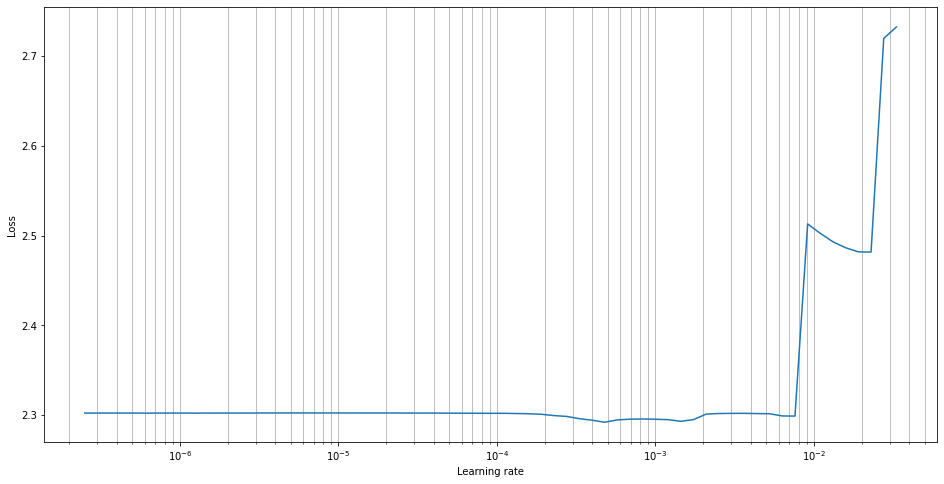

In [8]:
"""
  Znajdowanie learning rate
"""
class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
    self.optimizer = optimizer
    self.model = model
    self.criterion = criterion
    self.device = device
    torch.save(model.state_dict(), 'init_params.pt')

  def range_test(self, iterator, end_lr = 10, num_iter = 100,
      smooth_f = 0.05, diverge_th = 5):
    lrs = []
    losses = []
    best_loss = float('inf')
    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
    iterator = IteratorWrapper(iterator)

    for iteration in range(num_iter):
      loss = self._train_batch(iterator)
      lrs.append(lr_scheduler.get_last_lr()[0])
      # Aktualizacja learning rate
      lr_scheduler.step()
      if iteration > 0:
        loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

      if loss < best_loss:
        best_loss = loss

      losses.append(loss)

      if loss > diverge_th * best_loss:
        print("Stopping early, the loss has diverged")
        break

    # Reset modelu do wartości początkowych
    self.model.load_state_dict(torch.load('init_params.pt'))

    return lrs, losses

  def _train_batch(self, iterator):
    self.model.train()
    self.optimizer.zero_grad()
    x, y = iterator.get_batch()
    x = x.to(self.device)
    y = y.to(self.device)
    y_pred, _ = self.model(x)
    loss = self.criterion(y_pred, y)
    loss.backward()
    self.optimizer.step()
    return loss.item()


class ExponentialLR(_LRScheduler):
  def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)

  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels, *_ = next(self._iterator)

    return inputs, labels

  def get_batch(self):
    return next(self)
"""
  Wyrysowanie szukania learning rate
"""
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]

  fig = plt.figure(figsize = (16,8))
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both', 'x')
  plt.show()

# Oszacowanie learning rate
start = 1e-7
optimizer = optim.Adam(model.parameters(), lr = start)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
stop = 10 # skończ, gdy learning rate dojdzie do 10
iteration = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, stop, iteration)
plot_lr_finder(lrs, losses)

In [9]:
best_lr = lrs[losses.index(min(losses))]
print(best_lr)

0.0004786300923226385


In [0]:
# Funkcje uczenia modelu analogicznie jak w lab 4
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()    
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0 
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [11]:
# Szkolenie sieci z wyliczonym learning rate
optimizer = optim.Adam(model.parameters(), lr = best_lr) 
EPOCHS = 20
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 22s
	Train Loss: 1.769 | Train Acc: 32.09%
	 Val. Loss: 1.492 |  Val. Acc: 43.65%
Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 1.380 | Train Acc: 48.90%
	 Val. Loss: 1.229 |  Val. Acc: 54.95%
Epoch: 03 | Epoch Time: 0m 22s
	Train Loss: 1.213 | Train Acc: 56.07%
	 Val. Loss: 1.133 |  Val. Acc: 59.27%
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.090 | Train Acc: 60.82%
	 Val. Loss: 1.006 |  Val. Acc: 64.24%
Epoch: 05 | Epoch Time: 0m 22s
	Train Loss: 0.999 | Train Acc: 64.68%
	 Val. Loss: 0.891 |  Val. Acc: 68.86%
Epoch: 06 | Epoch Time: 0m 22s
	Train Loss: 0.925 | Train Acc: 67.43%
	 Val. Loss: 0.874 |  Val. Acc: 69.16%
Epoch: 07 | Epoch Time: 0m 22s
	Train Loss: 0.865 | Train Acc: 69.53%
	 Val. Loss: 0.826 |  Val. Acc: 70.97%
Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.819 | Train Acc: 71.33%
	 Val. Loss: 0.787 |  Val. Acc: 72.09%
Epoch: 09 | Epoch Time: 0m 22s
	Train Loss: 0.767 | Train Acc: 72.97%
	 Val. Loss: 0.764 |  Val. Acc: 73.39%
Epoch: 10 | Epoch T

FileNotFoundError: ignored

In [12]:
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.695 | Test Acc: 76.89%


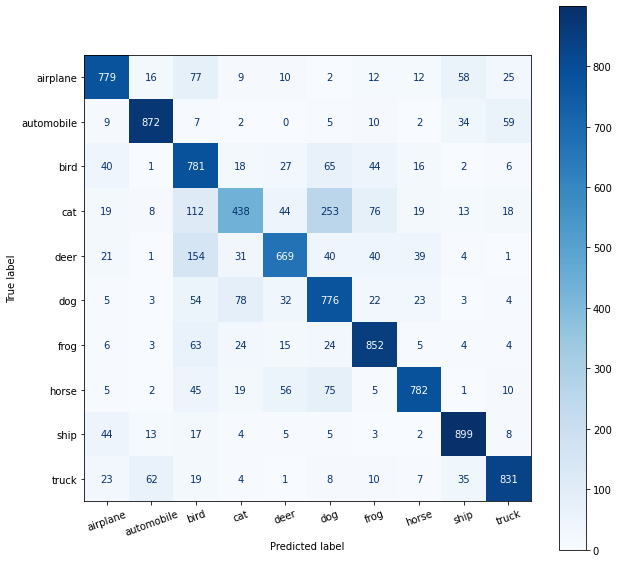

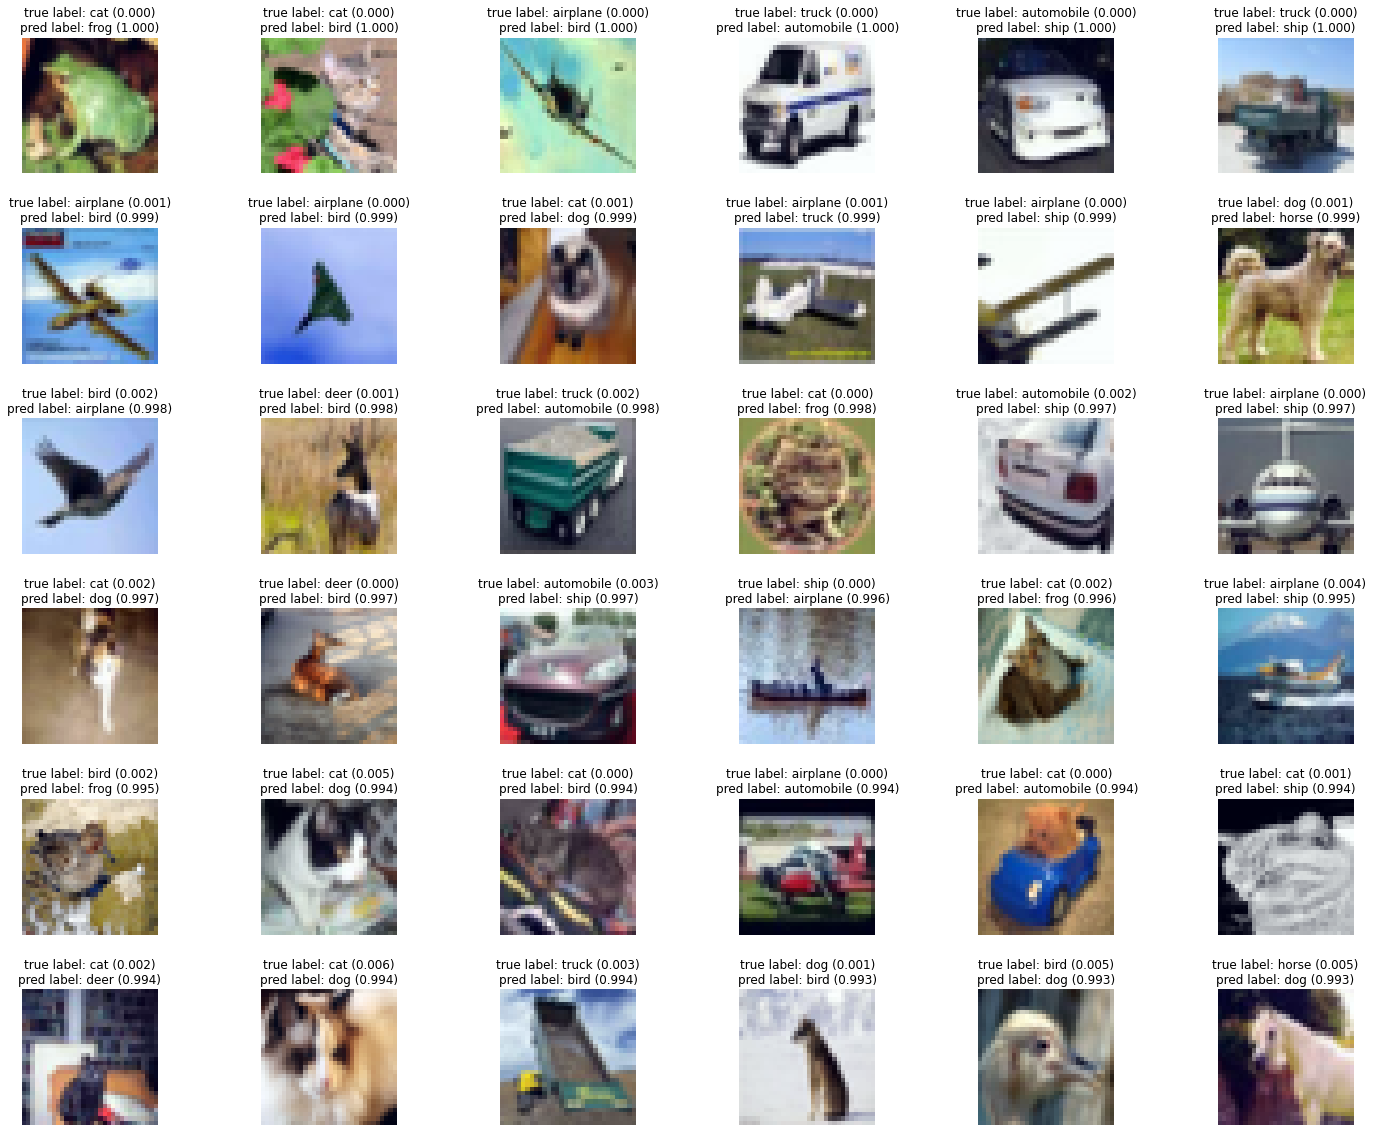

In [13]:
# Weryfikacja modelu
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs


def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)


def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)


images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

classes = test_data.classes

plot_confusion_matrix(labels, pred_labels, classes)

corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

plot_most_incorrect(incorrect_examples, classes, 40)